In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import  cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler
from natsort import natsorted

In [50]:
genuine_path = r'archive(1)\signatures\full_org'
forged_path = r'archive(1)\signatures\full_forg'

In [ ]:
# def extract_features(img):
#     img=cv2.resize(img,(256,128))
#     _, binary_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
#     hog_features = hog(binary_img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
#     lbp = local_binary_pattern(binary_img, P=24, R=3, method="uniform")
#     (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
#     lbp_hist = lbp_hist.astype("float")
#     lbp_hist /= lbp_hist.sum()
#     moments = cv2.moments(binary_img)
#     hu_moments = cv2.HuMoments(moments).flatten()
#     features = np.hstack([hog_features, lbp_hist, hu_moments])
#     return features
def extract_features(img):
    # Resize to standardized dimensions
    img = cv2.resize(img, (256, 128))
    
    # Enhanced binarization with automatic background detection
    _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Ensure black signature on white background
    if np.sum(binary_img) < (binary_img.size * 255 / 2):
        binary_img = cv2.bitwise_not(binary_img)
    
    # 1. HOG Features (from grayscale image)
    hog_features = hog(img, 
                      pixels_per_cell=(16, 16),
                      cells_per_block=(2, 2),
                      feature_vector=True)
    
    # 2. LBP Features (from grayscale image)
    lbp = local_binary_pattern(img, P=24, R=3, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
    lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-7)  # Add epsilon to avoid division by zero
    
    # 3. Hu Moments (from binary image)
    moments = cv2.moments(binary_img)
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Log-scale normalization for Hu Moments
    hu_moments = np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-7)
    
    # Combine all features
    features = np.hstack([hog_features, lbp_hist, hu_moments])
    
    return features


In [62]:
# def load_images(folder,label):
#     X_train=[]
#     X_test=[]
#     y_train=[]
#     y_test=[]
#     data_size = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
#     train_size=0.8*data_size
#     i=1
#     for filename in natsorted(os.listdir(folder)):
#         img_path=os.path.join(folder,filename)
#         img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
#         if img is not None:
#             i+=1
#             features=extract_features(img)
#             if(i<=train_size):
#                 X_train.append(features)
#                 y_train.append(label)
#             else:
#                 X_test.append(features)
#                 y_test.append(label)
#     return np.array(X_train),np.array(X_test),np.array(y_train),np.array(y_test)
def load_images(folder, label):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    file_list = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    data_size = len(file_list)
    train_size = int(0.8 * data_size)
    file_list = natsorted(file_list)  # Sort files naturally
    
    for i, filename in enumerate(file_list):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            features = extract_features(img)
            if i < train_size:
                X_train.append(features)
                y_train.append(label)
            else:
                X_test.append(features)
                y_test.append(label)
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)


In [63]:
real_X_train,real_X_test,real_y_train,real_y_test=load_images(genuine_path,label=0)
forged_X_train,forged_X_test,forged_y_train,forged_y_test=load_images(forged_path,label=1)


In [64]:
X_train=np.concatenate((real_X_train,forged_X_train), axis=0)
X_test=np.concatenate((real_X_test,forged_X_test), axis=0)
y_train=np.concatenate((real_y_train,forged_y_train), axis=0)
y_test=np.concatenate((real_y_test,forged_y_test), axis=0)


In [65]:
train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)


In [66]:
np.random.shuffle(train_data)  # Shuffles in-place
np.random.shuffle(test_data)

In [67]:

X_train_shuffled = train_data[:, :-1]
y_train_shuffled = train_data[:, -1]

X_test_shuffled = test_data[:, :-1]
y_test_shuffled = test_data[:, -1]


In [68]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [69]:
# X = np.concatenate((data_gen, data_forged), axis=0)
# y = np.concatenate((label_gen, label_forged), axis=0)
svm = SVC(kernel='linear', C=100.0)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)


In [70]:
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM Accuracy: 0.9735849056603774


In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [38]:
cm = confusion_matrix(y_test,y_pred_svm)

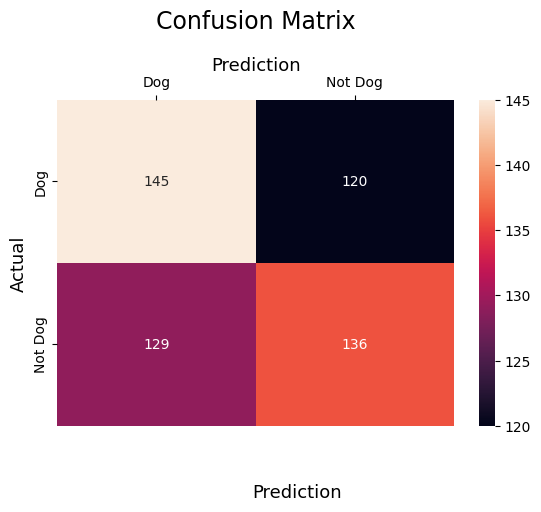

In [39]:
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Dog','Not Dog'],
            yticklabels=['Dog','Not Dog'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [47]:
rf = RandomForestClassifier(n_estimators=200, random_state=55)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [48]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.49056603773584906
